In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from skimage import data,img_as_ubyte
from skimage.util import random_noise
import copy
from numpy import linalg as LA
from skimage.metrics import peak_signal_noise_ratio
from sklearn.preprocessing import normalize
from scipy import ndimage
from numpy import asarray
from scipy.spatial import distance
import random
from math import log10, sqrt
from scipy.sparse import csr_matrix
from scipy import sparse
import cv2
from scipy.sparse import identity
import sys
from scipy.optimize import minimize

#PSNR and RMSE for assessment of image

In [3]:
def RMSE(original_image, smoothed_image):
  #It meaures the similiarity between to images
  #Input: Two images (image1 and image 2)
  #Output: A number which is used as the metrics of simiralrity of two images
  rmse = np.sqrt(((original_image - smoothed_image) ** 2).mean())
  return rmse

In [4]:
def PSNR(image1, image2):
    #It meaures the similiarity between to images
    #Input: Two images (image1 and image 2)
    #Output: A number which is used as the metrics of simiralrity of two images
    mse = np.mean((image1 - image2)**2)
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(1 / np.sqrt(mse))
    return psnr

#Downsampling matrix

In [5]:
def matrix_donsampling(image,z):
   #It compute downsampling followed by local avarage matrix
   #Input: Grayscale image A, and downsampling factor
   #Output: transformation matric for downsampling by factor z
  [Ah,Aw]=image.shape
  #print('size image is Ah=%.f, Aw=%.f'%(Ah,Aw))
  A=csr_matrix((Ah-z+1,Aw)).toarray()
  #print(A)
  #print('Size Matrix A:')
  #print(A.shape)
  for i in range(Ah-z+1):
    for j in range(i,i+z):
        A[i][j]=1
  A[-1][-1]=1
  #print(A)
  B=np.divide(sparse.kron(A,A),z**2)
  #print('Size Matrix B:')
  #print(B.shape)
  #print(B)
  I1=sparse.eye(Ah,Ah-z+1).toarray()
  #print('Size Matrix I1:')
  #print(I1.shape)
  #print(I1)
  Q=I1[0:Ah-z+2:z,:]
  #print('Size Matrix Q:')
  #print(Q.shape)
  #print(Q)
  D=sparse.kron(Q,Q)
  #print('Size Matrix D:')
  #print(D.shape)
  #print(D)
  H=np.multiply(D,B)
  #print('Size Matrix H:')
  #print(H.shape)
  #print(H)
  return H

#Drivatives of image

In [6]:
def forwarddifference(A):
    #It compute forward difference matrix of an image
    #Input: Grayscale image A
    #Output: Matrix u_x, u_y specifying the forward difference in x direction
    # and  forward difference in y direction, respectively
    
    #forward difference in x direction
    B=np.column_stack((A[:,1:],A[:,-1]))
    u_x=B-A

    #forward difference in y direction
    C=np.row_stack((A[1:,:],A[-1,:]))
    u_y=C-A
    return u_x,u_y

In [7]:
def Backwarddifference(A):
    #It compute Backward difference matrix of an image
    #Input: Grayscale image A
    #Output: Matrix u_x, u_y specifying the forward difference in x direction
    # and  Backward difference in y direction, respectively
    
    #Backward difference in x direction
    B1=np.column_stack((A[:,0],A[:,:-1]))#repeating last column for bundary condition
    u_x=A-B1
    #Backward difference in y direction
    C1=np.row_stack((A[0,:],A[:-1,:]))#repeating last column for bundary condition
    u_y=A-C1
    return u_x,u_y

In [8]:
def Centralddifference(A):
    #It compute cantral difference matrix of an image
    #Input: Grayscale image A
    #Output: Matrix u_x, u_y specifying the central difference in x direction
    # and central difference in y direction, respectively
    
    #Central difference in x direction
    B=np.column_stack((A[:,1:],A[:,-1]))
    B1=np.column_stack((A[:,0],A[:,:-1]))
    u_x=(B-B1)/2

    #Central difference in y direction
    C=np.row_stack((A[1:,:],A[-1,:]))
    C1=np.row_stack((A[0,:],A[:-1,:]))
    u_y=(C-C1)/2
    return u_x,u_y

In [9]:
def secondderivative(A):
    #It compute second cantral difference matrix of an image
    #Input: Grayscale image A
    #Output: Matrix u_xx, u_yy specifying the second order central difference in x direction
    # and the second order central difference in y direction, respectively

    #the second order central difference in x direction
    B=np.column_stack((A[:,1:],A[:,-1]))
    B1=np.column_stack((A[:,0],A[:,:-1]))
    u_xx=(B-2*A+B1)

    #the second order central difference in y direction
    C=np.row_stack((A[1:,:],A[-1,:]))
    C1=np.row_stack((A[0,:],A[:-1,:]))
    u_yy=(C-2*A+C1)
    return u_xx,u_yy

In [10]:
def mixedpartialderivative(A):
  # It computes diagonal derivative matrix of an image
  #Input: Grayscale image A
  #Output: Matrix u_xy specifying the diagnal deriarive
  [m,n]=A.shape
  if n==1 or m==1:
    u_xy=np.zeros((m,n))
  else:
    P1=np.row_stack((A[1:,1:],A[-1,1:]))
    Q1=np.column_stack((P1,P1[:,-1]))
    P2=np.row_stack((A[0,:-1],A[:-1,:-1]))
    Q2=np.column_stack((P2[:,0],P2))
    P3=np.row_stack((A[1:,:-1],A[-1,:-1]))
    Q3=np.column_stack((P3[:,0],P3))
    P4=np.row_stack((A[0,1:],A[:-1,1:]))
    Q4=np.column_stack((P4,P4[:,-1]))
    u_xy=(Q1+Q2-Q3-Q4)/4
  return u_xy

In [11]:
def Reg(y):
  #It computes regularization function and its derivative 
  #Input: 2D array:y
  #Output: regularization :G and its derivative:derivative_of_G
  a=0.01
  u_x,u_y=Centralddifference(y)
  A1=u_x**2+u_y**2
  A2=np.sqrt((A1))
  A3=np.sum(A2)
  u_xx,u_yy=secondderivative(y)
  u_xy=mixedpartialderivative(y)
  C=np.multiply(u_x,u_y)
  A1=np.multiply(u_xx ,u_y**2)-2*np.multiply(C,u_xy)+ np.multiply(u_yy ,u_x**2)
  A2=a + (u_x**2 + u_y**2)**(3/2)
  derivative_of_G=-np.divide(A1,A2)
  return A3,derivative_of_G

In [12]:
def zeroaverage(y):
 #It gives us mean zero vector
  #Input: y vecotr
  #output:zero mean vector
  y_average=y.mean()
  y_new=y-y_average
  return y_new

In [13]:
def S1(x,H,y, epsilon1):
   #It compute S1 in formula
    #Input: Vector:X, Vector: y, epsilon1
    #Output: scalar
  R=(2*np.mean(x)*np.mean(H@y)+epsilon1)/(np.mean(x)**2+np.mean(H@y)**2+epsilon1)
  return R

In [14]:
def S2(x,H,y, epsilon2):
   #It compute S2 in formula
    #Input: Vector : X, Vector y, epsilon2
    #Output: scalar 
  R1=np.linalg.norm(zeroaverage(x)+zeroaverage(H@y),ord=2)**2-np.linalg.norm(zeroaverage(x), ord=2)**2-np.linalg.norm(zeroaverage(H@y),ord=2)**2+epsilon2
  R2=np.linalg.norm(zeroaverage(x),ord=2)**2+np.linalg.norm(zeroaverage(H@y),ord=2)**2+epsilon2
  R=R1/R2
  return R

In [15]:
def DerS1(x,H,y, epsilon1):
   #It compute derivative of S1 in formula
    #Input: Transformation matrix H, Start (point) Grayscale image x, Degraded Grayscale image z, epsilon1
    #Output: vector
  [n,m]=H.shape
  R1=(2/n)*H.T@np.ones((1,int(n))).T*(np.mean(x)-np.mean(H@y)*S1(x,H,y,epsilon1))
  R2=(np.mean(x)**2+np.mean(H@y)**2+epsilon1)
  R=R1.reshape(-1)/R2
  return R

In [16]:
def DerS2(x,H,y,epsilon2):
  #It compute derivative of S2 in formula
    #Input: transformation matrix H, vector X, vector y, epsilon2
    #Output: vector
  [n,m]=H.shape
  R1=zeroaverage(x)
  R2=-S2(x,H,y,epsilon2)*(H@y)
  R3=S2(x,H,y,epsilon2)*np.ones((n,1))*np.mean(H@y)
  R4=R1+R2+R3.reshape(-1)
  R5=np.ones((n,1))*np.mean(R4)
  R6=2*H.T@R4
  R7=-2*H.T@R5
  R=R6+R7.reshape(-1)
  R8=np.linalg.norm(zeroaverage(x),ord=2)**2+np.linalg.norm(zeroaverage(H@y),ord=2)**2+epsilon2
  Ans=R/R8
  return Ans

In [17]:
def funcssim(p,x,H,y,epsilon1,epsilon2):
   #It compute ssim mean and its deivative
    #Input: P:weight,H:transformation matrix; a list of Vector:X, Vecor:z, epsilon1:scalar, epsilon1:Scalar
    #Output: scalar 
  sum1=0
  for i in range(len(x)):
    S_i=p[i]*S1(x[i],H,y,epsilon1)*S2(x[i],H,y,epsilon2)
    sum1=sum1+S_i
  sum1=len(x)-sum1
  sum2=0
  for j in range(len(x)):
    S_j=p[j]*((DerS1(x[j],H,y,epsilon1)*S2(x[j],H,y,epsilon2)+DerS2(x[j],H,y,epsilon2)*S1(x[j],H,y,epsilon1)))
    sum2=sum2+S_j
  sum2=-sum2
  return sum1,sum2

In [18]:

def objective(p,x,H,y,epsilon1,epsilon2,Lambda):
  X=[]
  for j in range(len(x)):
    a=x[j].reshape(-1)
    X.append(a)
  obj1,der_obj1=funcssim(p,X,H,y.reshape(-1),epsilon1,epsilon2)
  obj2,der_obj2=Reg(y.reshape(m1,n1))
  obj=obj1+Lambda*obj2
  der_obj=der_obj1.reshape(-1)+Lambda*der_obj2.reshape(-1)
  return obj

In [19]:

def Der(p,x,H,y,epsilon1,epsilon2,Lambda):

  [m,n]=x[0].shape
  X=[]
  for j in range(len(x)):
    a=x[j].reshape(-1)
    X.append(a)
  obj1,der_obj1=funcssim(p,X,H,y.reshape(-1),epsilon1,epsilon2)
  obj2,der_obj2=Reg(y.reshape(m1,n1))
  obj=obj1+Lambda*obj2
  der_obj=der_obj1.reshape(-1)+Lambda*der_obj2.reshape(-1)
  return der_obj

In [20]:
Func=lambda y:objective(p,x,H,y,epsilon1,epsilon2,Lambda)
DerFunc=lambda y1:Der(p,x,H,y1,epsilon1,epsilon2,Lambda)

In [21]:
#EXAMPLE1
A=np.array([[0.1]])
B=np.array([[0.4]])
C=np.array([[0.1]])
x=[A,B]
[M12,M22]=A.shape
N=M12*M22
H=identity(N)
epsilon1=0
epsilon2=0.03
p=[1,1]
Lambda=0
y=C
global m1,n1
[m1,n1]=y.shape
T1= minimize(Func, C.reshape(-1), method='BFGS', jac=DerFunc)
T2= minimize(Func, C.reshape(-1), method='CG', jac=DerFunc)
T3=minimize(Func, C.reshape(-1), method='Powell')
T4=minimize(Func, C.reshape(-1), method='Newton-CG', jac=DerFunc)
T5=minimize(Func, C.reshape(-1), bounds=[(0,2)], method='L-BFGS-B', jac=DerFunc)
T6= minimize(Func, C.reshape(-1), method='TNC', jac=DerFunc)
T7= minimize(Func, C.reshape(-1), method='COBYLA')
T8=minimize(Func, C.reshape(-1), bounds=[(0,1)], method='SLSQP', jac=DerFunc)
T9=minimize(Func, C.reshape(-1), method='trust-constr')


In [22]:
from scipy.optimize import minimize_scalar
res = minimize_scalar(Func, method='bounded', bounds=(0, 1))
res

 message: Solution found.
 success: True
  status: 0
     fun: 0.40000000000125935
       x: 0.19999952580508798
     nit: 12
    nfev: 12

In [23]:
print('Result By starting C=0.05993848194 and BFGS method ')
print(T1)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and CG method ')
print(T2)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and Powell method ')
print(T3)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and Newton-CG method ')
print(T4)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and L-BFGS-B method ')
print(T5)
print('Result By starting   C=0.05993848194 and TNC method ')
print(T6)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and COBYLA method ')
print(T7)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and SLSQP method ')
print(T8)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and trust-constr method ')
print(T9)
print('------------------------------------')

Result By starting C=0.05993848194 and BFGS method 
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.3999999999999999
        x: [ 2.000e-01]
      nit: 7
      jac: [-9.677e-09]
 hess_inv: [[ 8.934e-02]]
     nfev: 9
     njev: 9
------------------------------------
Result By starting   C=0.05993848194 and CG method 
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.40000000000041913
       x: [ 2.000e-01]
     nit: 1
     jac: [ 3.064e-06]
    nfev: 11
    njev: 9
------------------------------------
Result By starting   C=0.05993848194 and Powell method 
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.3999999999999999
       x: [ 2.000e-01]
     nit: 2
   direc: [[ 3.307e-04]]
    nfev: 36
------------------------------------
Result By starting   C=0.05993848194 and Newton-CG method 
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun:

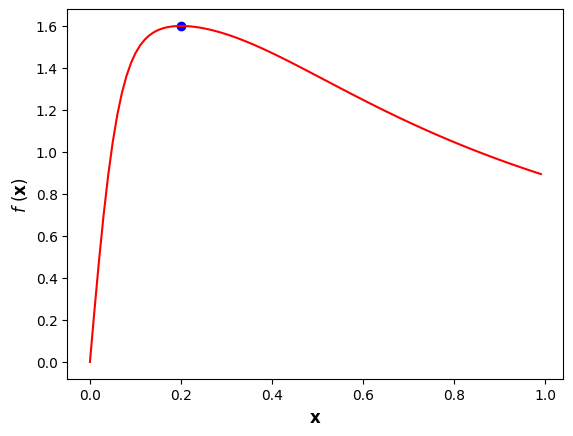

In [24]:

# Import our modules that we are using
import matplotlib.pyplot as plt
import numpy as np
A=np.array([[0.1]])
B=np.array([[0.4]])
C=np.array([[0.2]])
x=[A,B]
[M12,M22]=A.shape
N=M12*M22
H=identity(N)
epsilon1=0
epsilon2=0.03
p=[1,1]
Lambda=0
# Create the vectors X and Y
xx=[]
yy=[]
for i in np.arange(0,1,0.01):
  xxxx=np.array([[i]])
  yyyy = S1(A,H,xxxx,epsilon1)+S1(B,H,xxxx,epsilon1)
  xx.append(np.squeeze(xxxx))
  yy.append(yyyy)
# Create the plot

plt.plot(xx,yy,'r')
roots=[2.000e-01]
maxvalue = S1(A,H,roots,epsilon1)+S1(B,H,roots,epsilon1)
plt.scatter(roots, maxvalue,c='b')
plt.xlabel("$\mathbf{x}$", fontsize=12)
plt.ylabel("$f~(\mathbf{x})$", fontsize=12)
#Show the plot
plt.show()

In [25]:
#EXAMPLE2
A=np.array([[0.05]])
B=np.array([[0.8]])
C=np.array([[0.8]])
x=[A,B]
[M12,M22]=A.shape
N=M12*M22
H=identity(N)
epsilon1=0
epsilon2=0.03
p=[1,1]
Lambda=0
y=C
global m1,n1
[m1,n1]=y.shape
T1= minimize(Func, C.reshape(-1), method='BFGS', jac=DerFunc)
T2= minimize(Func, C.reshape(-1), method='CG', jac=DerFunc)
T3=minimize(Func, C.reshape(-1), method='Powell')
T4=minimize(Func, C.reshape(-1), method='Newton-CG', jac=DerFunc)
T5=minimize(Func, C.reshape(-1), bounds=[(0,2)], method='L-BFGS-B', jac=DerFunc)
T6= minimize(Func, C.reshape(-1), method='TNC', jac=DerFunc)
T7= minimize(Func, C.reshape(-1), method='COBYLA')
T8=minimize(Func, C.reshape(-1), bounds=[(0,1)], method='SLSQP', jac=DerFunc)
T9=minimize(Func, C.reshape(-1), method='trust-constr')

In [26]:
print('Result By starting C=0.05993848194 and BFGS method ')
print(T1)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and CG method ')
print(T2)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and Powell method ')
print(T3)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and Newton-CG method ')
print(T4)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and L-BFGS-B method ')
print(T5)
print('Result By starting   C=0.05993848194 and TNC method ')
print(T6)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and COBYLA method ')
print(T7)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and SLSQP method ')
print(T8)
print('------------------------------------')
print('Result By starting   C=0.05993848194 and trust-constr method ')
print(T9)
print('------------------------------------')

Result By starting C=0.05993848194 and BFGS method 
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.8666666666934488
        x: [ 6.922e-01]
      nit: 4
      jac: [-9.521e-06]
 hess_inv: [[ 5.980e-01]]
     nfev: 5
     njev: 5
------------------------------------
Result By starting   C=0.05993848194 and CG method 
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.8666666666666667
       x: [ 6.922e-01]
     nit: 3
     jac: [ 6.002e-09]
    nfev: 7
    njev: 7
------------------------------------
Result By starting   C=0.05993848194 and Powell method 
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.8666666666667648
       x: [ 6.922e-01]
     nit: 2
   direc: [[ 1.000e+00]]
    nfev: 26
------------------------------------
Result By starting   C=0.05993848194 and Newton-CG method 
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0

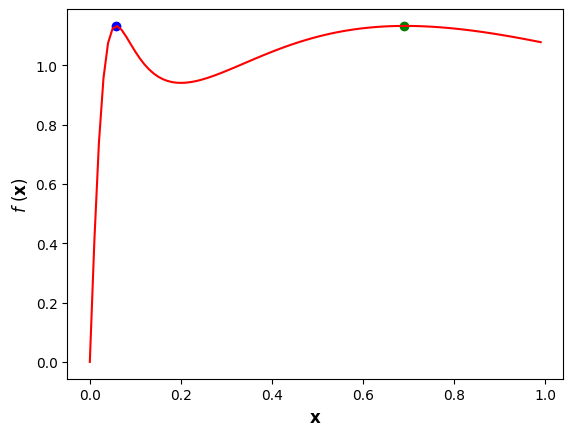

In [27]:
A=np.array([[0.05]])
B=np.array([[0.8]])
C=np.array([[0.8]])
x=[A,B]
[M12,M22]=A.shape
N=M12*M22
H=identity(N)
epsilon1=0
epsilon2=0.03
p=[1,1]
Lambda=0
# Create the vectors X and Y
xx=[]
yy=[]
for i in np.arange(0,1,0.01):
  xxxx=np.array([[i]])
  yyyy = S1(A,H,xxxx,epsilon1)+S1(B,H,xxxx,epsilon1)
  xx.append(np.squeeze(xxxx))
  yy.append(yyyy)
# Create the plot

plt.plot(xx,yy,'r')
roots=[0.057]
maxvalue = S1(A,H,roots,epsilon1)+S1(B,H,roots,epsilon1)
plt.scatter(roots, maxvalue,c='b')
roots=[0.69]
maxvalue = S1(A,H,roots,epsilon1)+S1(B,H,roots,epsilon1)
plt.scatter(roots, maxvalue,c='g')
plt.xlabel("$\mathbf{x}$", fontsize=12)
plt.ylabel("$f~(\mathbf{x})$", fontsize=12)
#Show the plot
plt.show()